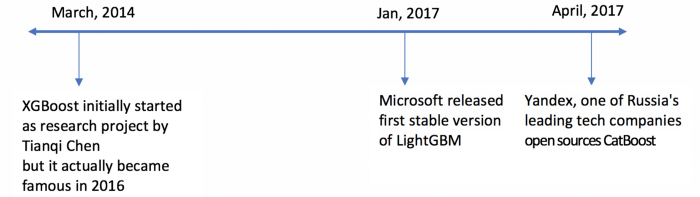

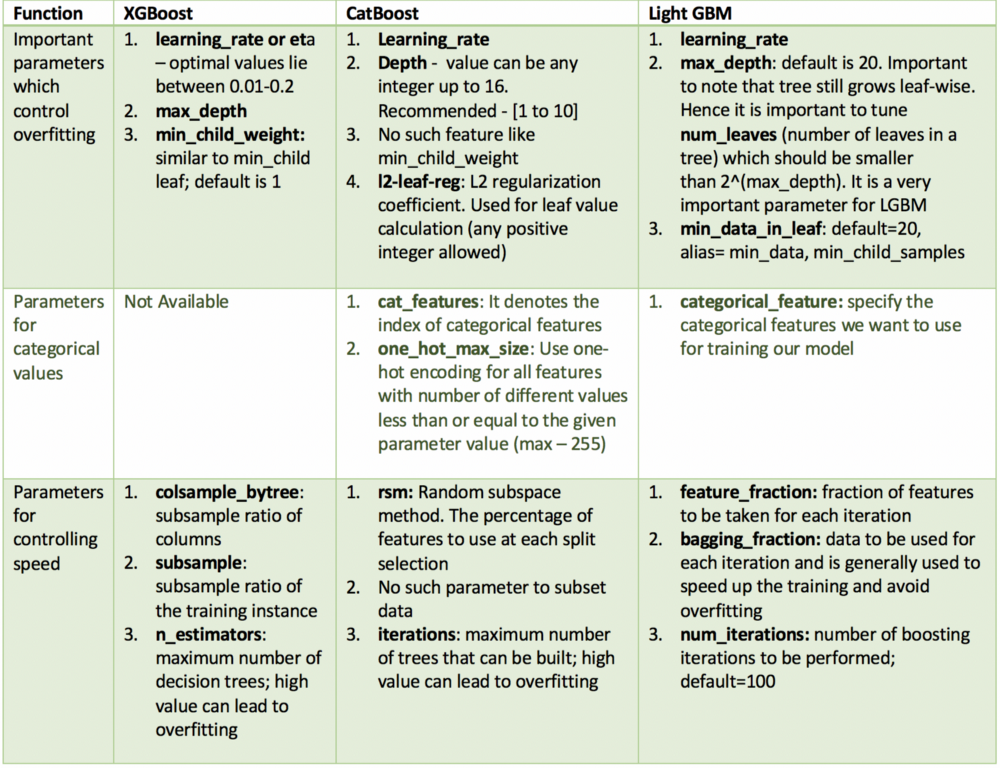

# XGBoost / LightGBM / CatBoost对比

In [160]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split

# 读取数据
data = pd.read_csv("https://cdn.coggle.club/kaggle-flight-delays/flights_10k.csv.zip")

# 提取有用的列
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

# 筛选出部分数据
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

# 进行编码
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

# 划分训练集和测试集
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)

In [161]:
data

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,1,4,2,88,253,13,169.0,2354.0,1448,0
1,1,1,4,1,2120,213,164,263.0,2.0,2330,0
2,1,1,4,12,803,60,262,266.0,18.0,2296,0
3,1,1,4,1,238,185,164,258.0,15.0,2342,0
4,1,1,4,2,122,14,261,199.0,24.0,1448,0
...,...,...,...,...,...,...,...,...,...,...,...
9994,1,1,4,8,2399,44,215,62.0,1710.0,473,0
9995,1,1,4,7,149,128,210,28.0,1716.0,100,1
9996,1,1,4,8,2510,208,76,29.0,1653.0,147,0
9997,1,1,4,8,2512,62,215,28.0,1721.0,135,1


In [7]:
import xgboost as xgb
# pip

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train, m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test, m.predict_proba(test)[:,1]))

# Parameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}

# 每组超参数训练过程中 ， 做了3折训练 ， 以3折的验证集的精度均值作为评价
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(train, y_train)

grid_search.best_estimator_

model = xgb.XGBClassifier(max_depth=3, min_child_weight=1,  n_estimators=20,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16)
model.fit(train,y_train)

print(auc(model, train, test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


(0.7479275227922775, 0.7430946047035487)

In [11]:
import lightgbm as lgb
from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))

lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, 
                           scoring="roc_auc", verbose=5)
grid_search.fit(train,y_train)
grid_search.best_estimator_

d_train = lgb.Dataset(train, label=y_train, free_raw_data=False)
params = {"max_depth": 3, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 20}

# Without Categorical Features
model2 = lgb.train(params, d_train)
print(auc2(model2, train, test))

#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
print(auc2(model2, train, test))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
(0.7223327449052556, 0.7163025114730949)
(0.7966919355559529, 0.7588511985812025)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AIRLINE', 'DAY', 'DAY_OF_WEEK', 'DESTINATION_AIRPORT', 'MONTH', 'ORIGIN_AIRPORT']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [28]:
import catboost
cat_features_index = [0,1,2,3,4,5,6]

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [20],
         'silent': [True]}
cb = catboost.CatBoostClassifier()
cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
cb_model.fit(train, y_train)

# With Categorical features
clf = catboost.CatBoostClassifier(eval_metric="AUC", depth=3, silent=True,
                                  iterations= 20, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train)
print(auc(clf, train, test))

# With Categorical features
clf = catboost.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, silent=True,
                            depth=3, iterations= 20, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train, cat_features= cat_features_index)
print(auc(clf, train, test))

(0.6925058097962102, 0.7095016558239615)
(0.7700712258670003, 0.7561893775110529)


使用500K数据

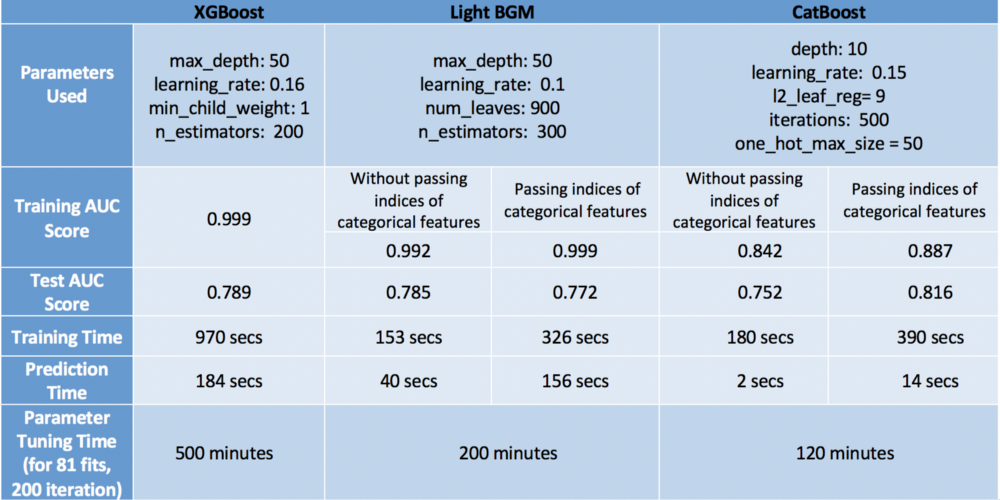

https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db

# LightGBM高阶使用

For Faster Speed
----------------

-  Use bagging by setting ``bagging_fraction`` and ``bagging_freq``

-  Use feature sub-sampling by setting ``feature_fraction``

-  Use small ``max_bin``

-  Use ``save_binary`` to speed up data loading in future learning

-  Use parallel learning, refer to `Parallel Learning Guide <./Parallel-Learning-Guide.rst>`__


For Better Accuracy
-------------------

-  Use large ``max_bin`` (may be slower)

-  Use small ``learning_rate`` with large ``num_iterations``

-  Use large ``num_leaves`` (may cause over-fitting)

-  Use bigger training data

-  Try ``dart``

Deal with Over-fitting
----------------------

-  Use small ``max_bin``

-  Use small ``num_leaves``

-  Use ``min_data_in_leaf`` and ``min_sum_hessian_in_leaf``

-  Use bagging by set ``bagging_fraction`` and ``bagging_freq``

-  Use feature sub-sampling by set ``feature_fraction``

-  Use bigger training data

-  Try ``lambda_l1``, ``lambda_l2`` and ``min_gain_to_split`` for regularization

-  Try ``max_depth`` to avoid growing deep tree

-  Try ``extra_trees``

-  Try increasing ``path_smooth``

## 定义数据集

In [162]:
# coding: utf-8
import json
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

try:
    import cPickle as pickle
except BaseException:
    import pickle

# 安装方式：pip 或 源码
# 使用方式：命令行 或 代码调用，原生api 或 sklearn
    
print('Loading data...')
# load or create your dataset
# 数据集链接 https://github.com/Microsoft/LightGBM/tree/master/examples/binary_classification
df_train = pd.read_csv('https://cdn.coggle.club/LightGBM/examples/binary_classification/binary.train', header=None, sep='\t')
df_test = pd.read_csv('https://cdn.coggle.club/LightGBM/examples/binary_classification/binary.test', header=None, sep='\t')
W_train = pd.read_csv('https://cdn.coggle.club/LightGBM/examples/binary_classification/binary.train.weight', header=None)[0]
W_test = pd.read_csv('https://cdn.coggle.club/LightGBM/examples/binary_classification/binary.test.weight', header=None)[0]

y_train = df_train[0]
y_test = df_test[0]
X_train = df_train.drop(0, axis=1)
X_test = df_test.drop(0, axis=1)

num_train, num_feature = X_train.shape

# create dataset for lightgbm
# if you want to re-use data, remember to set free_raw_data=False
lgb_train = lgb.Dataset(X_train, y_train,
                        weight=W_train, free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,
                       weight=W_test, free_raw_data=False)

Loading data...


## 训练保存模型

In [163]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# generate feature names
feature_name = ['feature_' + str(col) for col in range(num_feature)]

print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=[21])

print('Finished first 10 rounds...')
# check feature name
print('7th feature name is:', lgb_train.feature_name[6])

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Dumping model to JSON...')
# dump model to JSON (and save to file)
model_json = gbm.dump_model()

with open('model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

Starting training...
[1]	training's binary_logloss: 0.680148
[2]	training's binary_logloss: 0.671659
[3]	training's binary_logloss: 0.664139
[4]	training's binary_logloss: 0.655377
[5]	training's binary_logloss: 0.64739
[6]	training's binary_logloss: 0.640583
[7]	training's binary_logloss: 0.634757
[8]	training's binary_logloss: 0.628112
[9]	training's binary_logloss: 0.621807
[10]	training's binary_logloss: 0.615984
Finished first 10 rounds...
7th feature name is: feature_6
Saving model...
Dumping model to JSON...


## 特征重要性

In [87]:
# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

Feature names: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28']
Feature importances: [44, 15, 14, 58, 6, 125, 20, 6, 6, 60, 20, 10, 0, 42, 15, 17, 0, 24, 8, 18, 1, 22, 152, 14, 86, 146, 120, 151]


## 加载模型

In [88]:
print('Loading model to predict...')
# load model to predict
bst = lgb.Booster(model_file='model.txt')

# can only predict with the best iteration (or the saving iteration)
y_pred = bst.predict(X_test)

# eval with loaded model
print("The rmse of loaded model's prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

print('Dumping and loading model with pickle...')
# dump model with pickle
with open('model.pkl', 'wb') as fout:
    pickle.dump(gbm, fout)

# load model with pickle to predict
with open('model.pkl', 'rb') as fin:
    pkl_bst = pickle.load(fin)
# can predict with any iteration when loaded in pickle way
y_pred = pkl_bst.predict(X_test, num_iteration=7)
# eval with loaded model
print("The rmse of pickled model's prediction is:", mean_squared_error(y_test, y_pred) ** 0.5)

Loading model to predict...
The rmse of loaded model's prediction is: 0.4638594170866421
Dumping and loading model with pickle...
The rmse of pickled model's prediction is: 0.47202551524914116


## 继续训练

In [ ]:
# continue training
# init_model accepts:
# 1. model file name
# 2. Booster()
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model='model.txt',
                valid_sets=lgb_eval)

print('Finished 10 - 20 rounds with model file...')

## 修改超参数

In [89]:
# decay learning rates
# learning_rates accepts:
# 1. list/tuple with length = num_boost_round
# 2. function(curr_iter)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                valid_sets=lgb_eval)

print('Finished 20 - 30 rounds with decay learning rates...')

# change other parameters during training
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                valid_sets=lgb_eval,
                callbacks=[lgb.reset_parameter(bagging_fraction=[0.7] * 5 + [0.6] * 5)])

print('Finished 30 - 40 rounds with changing bagging_fraction...')

[41]	valid_0's binary_logloss: 0.617656
[42]	valid_0's binary_logloss: 0.61379
[43]	valid_0's binary_logloss: 0.609111
[44]	valid_0's binary_logloss: 0.604809
[45]	valid_0's binary_logloss: 0.601201
[46]	valid_0's binary_logloss: 0.597987
[47]	valid_0's binary_logloss: 0.594549
[48]	valid_0's binary_logloss: 0.590946
[49]	valid_0's binary_logloss: 0.58786
[50]	valid_0's binary_logloss: 0.58615
Finished 20 - 30 rounds with decay learning rates...
[51]	valid_0's binary_logloss: 0.617564
[52]	valid_0's binary_logloss: 0.614136
[53]	valid_0's binary_logloss: 0.609914
[54]	valid_0's binary_logloss: 0.60589
[55]	valid_0's binary_logloss: 0.6017
[56]	valid_0's binary_logloss: 0.598657
[57]	valid_0's binary_logloss: 0.59572
[58]	valid_0's binary_logloss: 0.594239
[59]	valid_0's binary_logloss: 0.591647
[60]	valid_0's binary_logloss: 0.589725
Finished 30 - 40 rounds with changing bagging_fraction...


## 自定义损失函数

In [90]:
# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
# log likelihood loss
def loglikelihood(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1. - preds)
    return grad, hess


# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
# binary error
# NOTE: when you do customized loss function, the default prediction value is margin
# This may make built-in evalution metric calculate wrong results
# For example, we are doing log likelihood loss, the prediction is score before logistic transformation
# Keep this in mind when you use the customization
def binary_error(preds, train_data):
    labels = train_data.get_label()
    preds = 1. / (1. + np.exp(-preds))
    return 'error', np.mean(labels != (preds > 0.5)), False


gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10,
                init_model=gbm,
                fobj=loglikelihood,
                feval=binary_error,
                valid_sets=lgb_eval)

print('Finished 40 - 50 rounds with self-defined objective function and eval metric...')

[61]	valid_0's binary_logloss: 5.11122	valid_0's error: 0.282
[62]	valid_0's binary_logloss: 5.57209	valid_0's error: 0.296
[63]	valid_0's binary_logloss: 5.17695	valid_0's error: 0.288
[64]	valid_0's binary_logloss: 5.23134	valid_0's error: 0.28
[65]	valid_0's binary_logloss: 5.51848	valid_0's error: 0.29
[66]	valid_0's binary_logloss: 5.31948	valid_0's error: 0.276
[67]	valid_0's binary_logloss: 5.23594	valid_0's error: 0.278
[68]	valid_0's binary_logloss: 5.28474	valid_0's error: 0.274
[69]	valid_0's binary_logloss: 5.39262	valid_0's error: 0.282
[70]	valid_0's binary_logloss: 5.44993	valid_0's error: 0.282
Finished 40 - 50 rounds with self-defined objective function and eval metric...


# 模型调参方法

In [63]:
d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 4, "learning_rate" : 0.05, "num_leaves": 250, 
          'n_estimators': 600}

data = lgb.cv(params, d_train, num_boost_round=350, 
              nfold=5, metrics='auc')
print(pd.DataFrame(data))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:430: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


     auc-mean  auc-stdv
0    0.648399  0.015209
1    0.660574  0.021048
2    0.663751  0.016943
3    0.667220  0.017675
4    0.671247  0.007378
..        ...       ...
595  0.743641  0.007673
596  0.743653  0.007720
597  0.743665  0.007693
598  0.743677  0.007649
599  0.743642  0.007653

[600 rows x 2 columns]


In [65]:
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [4,5, 7],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [50, 100, 150]
             }
grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 5, scoring="roc_auc", verbose=5)
grid_search.fit(train,y_train)
grid_search.best_estimator_, grid_search.best_score_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


(LGBMClassifier(max_depth=5, n_estimators=150, num_leaves=300, silent=False),
 0.7474793776907569)

- https://github.com/fmfn/BayesianOptimization

In [75]:
import warnings
import time
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization

def lgb_eval(max_depth, learning_rate, num_leaves, n_estimators):
    params = {
             "metric" : 'auc'
        }
    params['max_depth'] = int(max(max_depth, 1))
    params['learning_rate'] = np.clip(0, 1, learning_rate)
    params['num_leaves'] = int(max(num_leaves, 1))
    params['n_estimators'] = int(max(n_estimators, 1))
    cv_result = lgb.cv(params, d_train, nfold=5, seed=0, verbose_eval =200,stratified=False)
    return 1.0 * np.array(cv_result['auc-mean']).max()


lgbBO = BayesianOptimization(lgb_eval, {'max_depth': (4, 8),
                                            'learning_rate': (0.05, 0.2),
                                            'num_leaves' : (20,1500),
                                            'n_estimators': (5, 200)}, random_state=0)

lgbBO.maximize(init_points=5, n_iter=50,acq='ei')
print(lgbBO.max)

|   iter    |  target   | learni... | max_depth | n_esti... | num_le... |
-------------------------------------------------------------------------
|  1        |  0.7335   |  0.1323   |  6.861    |  122.5    |  826.4    |
|  2        |  0.7334   |  0.1135   |  6.584    |  90.33    |  1.34e+03 |
|  3        |  0.7334   |  0.1945   |  5.534    |  159.4    |  802.8    |
|  4        |  0.7243   |  0.1352   |  7.702    |  18.85    |  149.0    |
|  5        |  0.7306   |  0.05303  |  7.33     |  156.7    |  1.308e+0 |
|  6        |  0.6997   |  0.1597   |  5.141    |  5.17     |  1.392e+0 |
|  7        |  0.7342   |  0.1454   |  6.984    |  98.78    |  1.296e+0 |
|  8        |  0.7363   |  0.1276   |  5.413    |  175.7    |  873.1    |
|  9        |  0.7354   |  0.053    |  5.547    |  131.8    |  925.1    |
|  10       |  0.7293   |  0.1999   |  7.243    |  199.2    |  946.7    |
|  11       |  0.7353   |  0.1975   |  4.435    |  54.61    |  912.5    |
|  12       |  0.7355   |  0.1146   | 

# 误差分析方法

- https://eli5.readthedocs.io/en/latest/index.html
- https://github.com/slundberg/shap

# 模型部署

## 案例1

In [1]:
from lightgbm import LGBMClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
 
data = load_iris()
 
X, y = data["data"], data["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
 
clf = LGBMClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

print(clf.feature_importances_)

print(classification_report(y_test, clf.predict(
    X_test), target_names=data["target_names"]))
 
# pickle功能意义
joblib.dump(clf, 'lgb.pkl')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] Start training from score -1.171183
[LightGBM] [Info] Start training from score -1.049822
[LightGBM] [Info] Start training from score -1.078810
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

['lgb.pkl']

In [3]:
import joblib
 
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
 
data = load_iris()

X, y = data["data"], data["target"]
 
clf = joblib.load('data1.pkl')
 
print(clf.feature_importances_)
print(classification_report(y, clf.predict(
    X), target_names=data["target_names"]))

[131 164 186 164]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.98      1.00      0.99        50
   virginica       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



/home/lyz/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
import urllib, requests, json
post_data = { 'data': [5, 3. , 4.2, 1.5] } 
requests.post("http://192.168.12.100:9999", 
              data = json.dumps(post_data)).text

'{"label": 1, "code": 200, "msg": ""}'

## 案例2

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train',
    categories=None, shuffle=True, random_state=42)

In [6]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape

from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
clf = LGBMClassifier(max_depth=5, random_state=0, n_estimators=10)

# clf = MultinomialNB(alpha=.01)
clf.fit(vectors, newsgroups_train.target)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.223940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351140
[LightGBM] [Info] Number of data points in the train set: 11314, number of used features: 9198
[LightGBM] [Info] Start training from score -3.160010
[LightGBM] [Info] Start training from score -2.963895
[LightGBM] [Info] Start training from score -2.951980
[LightGBM] [Info] Start training from score -2.953674
[LightGBM] [Info] Start training from score -2.974222
[LightGBM] [Info] Start training from score -2.948602
[LightGBM] [Info] Start training from score -2.962184
[LightGBM] [Info] Start training from score -2.946917
[LightGBM] [

LGBMClassifier(max_depth=5, n_estimators=10, random_state=0)

In [7]:
joblib.dump((vectorizer, clf), 'data2.pkl')

['data2.pkl']

In [9]:
import urllib, requests, json
post_data = { 'data': newsgroups_train.data[510] } 
requests.post("http://127.0.0.1:9999", 
              data = json.dumps(post_data)).text

'{"label": 14, "code": 200}'

In [11]:
newsgroups_train.target[510]

14

In [13]:
newsgroups_train.data[509]

'From: tclock@orion.oac.uci.edu (Tim Clock)\nSubject: Re: ISLAM BORDERS vs Israeli borders\nNntp-Posting-Host: orion.oac.uci.edu\nOrganization: University of California, Irvine\nLines: 56\n\nIn article <C50wJJ.J4r@newsflash.concordia.ca> ilyess@ECE.Concordia.CA (Ilyess Bdira) writes:\n>In article <4805@bimacs.BITNET> ehrlich@bimacs.BITNET (Gideon Ehrlich) writes:\n>>\n>>What are the borders the Islamic world dreams about ??\n>\n>The Islamic world dreams of being the whole planet, but not by kicking\n>the current inhabitant out, we rather deam of the day everybody converts.\n>If Jews had the same dream, I would not feel threatened a bit.\n\nThere certainly are muslims who *do not* believe that their dream of \na global Islamic community should be achieved through force. There are, \nhowever, others (and, they are often far more visible/vocal than the \nformer) who *do* accept the establishment of global Islam through force. \nI  would *not* feel threatened by those only accepting or pur